In [1]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import datetime
import os
import numpy as np
import tensorflow as tf
import keras
import sklearn.model_selection as sk
import copy
from PIL import Image as IM
from keras.callbacks import TensorBoard
import cv2
import json
import pathlib
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
## import helpers
from helpers import data_loaders as dls
from helpers import pointcloud as pc
from helpers.viz import plot, plot_history, ConfusionMatrix
from helpers.logger import Logger
import utils
## import networks
from dl_models import get_unet_model
from evaluate_model import *

### Classic + Geometry

100%|██████████| 30/30 [00:00<00:00, 1451.95it/s]

{'name': 'experiment0', 'test_name': 'Classical_Geometric_', 'run_id': 'unet_2019_09_04_12_27', 'dataset': 'KITTI', 'training_config': {'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}}
{'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}
dict_keys(['imgs', 'calib', 'gt', 'gt_bev', 'gt_front', 'lodnn_gt', 'pc'])
Reading cloud
Reading calibration files


Reading camera images
(259, 2)
Height ranges from -30.21500015258789 to 2.9130001068115234
Evaluating count
Count varies from 0 to 17
Extracting features
Evaluated in : 3.1209957599639893
Test set shape (30, 64, 943, 9)
GT set shape (30, 64, 943, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 944, 9)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 944, 8)   656         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 472, 8)   0           conv2d_1[0][0]                   
_________________________________________________________

/home/leonardo/Dev/github/crispy-eureka/nbs/dl_models.py:109: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = keras.models.Model(input = inputs, output = conv10)


Elapsed time to exectute predict_sample: 1.3072071075439453
Elapsed time to exectute predict_sample: 0.009397506713867188
Elapsed time to exectute predict_sample: 0.009174585342407227
Elapsed time to exectute predict_sample: 0.009228706359863281
Elapsed time to exectute predict_sample: 0.009187698364257812
Elapsed time to exectute predict_sample: 0.009053468704223633
Elapsed time to exectute predict_sample: 0.00901341438293457
Elapsed time to exectute predict_sample: 0.009064912796020508
Elapsed time to exectute predict_sample: 0.009001731872558594
Elapsed time to exectute predict_sample: 0.009178876876831055
Elapsed time to exectute predict_sample: 0.009134769439697266
Elapsed time to exectute predict_sample: 0.009235858917236328
Elapsed time to exectute predict_sample: 0.009210824966430664
Elapsed time to exectute predict_sample: 0.009414434432983398
Elapsed time to exectute predict_sample: 0.00926828384399414
Elapsed time to exectute predict_sample: 0.009112119674682617
Elapsed time

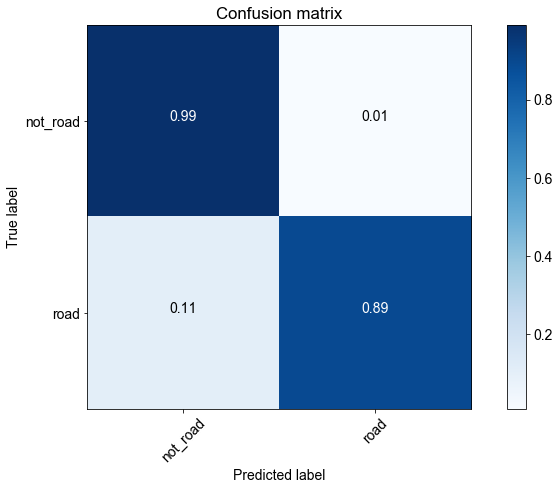

In [3]:
model_name = 'unet'
weights = 'output/experiment0/unet_2019_09_04_12_27/model/best_model.h5'
f_test_c_g, gt_test_c_g, model_c_g, scores_c_g, pred_c_g, times_c_g, conf_mat_c_g = evaluate_model(model_name, weights, view='front', plot_result_flag=False)

In [5]:
print("Scores:", scores_c_g)
print("Mean prediction time: ", times_c_g[1:].mean())

Scores: {'f1': 0.900647579566646, 'recall': 0.8916200774098421, 'precision': 0.9098597553712376, 'acc': 0.9823154162248144, 'jaccard': 0.819252828143699}
Mean prediction time:  0.00937766042248956


In [6]:
plt.style.use('classic')

11


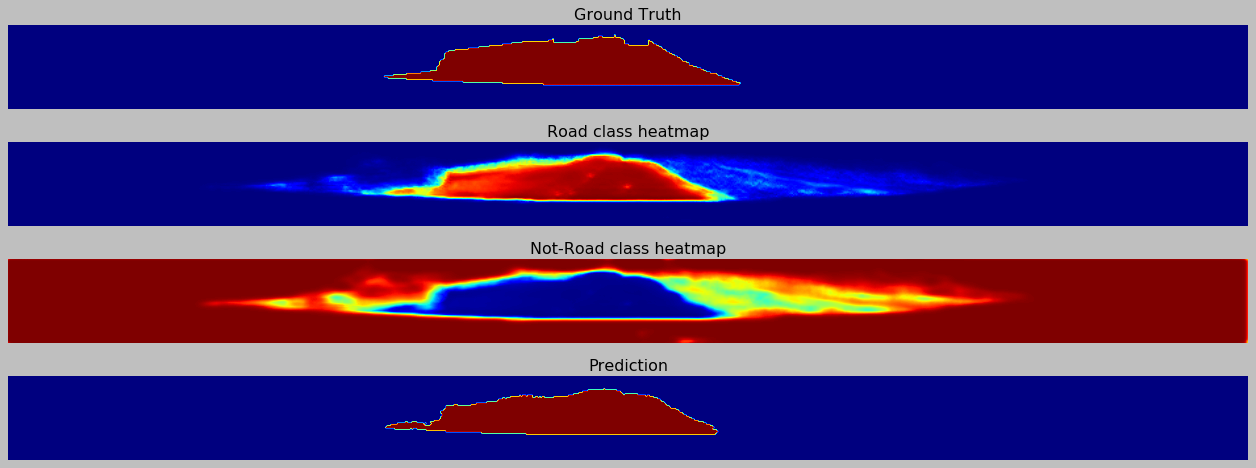

In [7]:
n = np.random.randint(len(gt_test_c_g))
print(n)
# n = 12
f, ax = plt.subplots(4, 1, figsize=(20,7))
ax[0].imshow(gt_test_c_g[n, :, :, 0])
ax[0].set_title('Ground Truth')
ax[0].axis('off')
ax[1].imshow(pred_c_g[n, :, :, 0])
ax[1].set_title('Road class heatmap'.format(n))
ax[1].axis('off')
ax[2].imshow(pred_c_g[n, :, :, 1])
ax[2].set_title('Not-Road class heatmap'.format(n))
ax[2].axis('off')

ax[3].imshow(1 - np.argmax(pred_c_g[n, :, :, :], axis=2))
ax[3].set_title('Prediction'.format(n))
ax[3].axis('off')
# plt.tight_layout()
plt.savefig('pred_classic_geom_sub_hog.eps', dpi=90)

plt.show()

### Classic

100%|██████████| 30/30 [00:00<00:00, 3263.54it/s]

{'name': 'experiment0', 'test_name': 'Classical_', 'run_id': 'unet_2019_09_04_12_16', 'dataset': 'KITTI', 'training_config': {'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}}
{'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}
dict_keys(['imgs', 'calib', 'gt', 'gt_bev', 'gt_front', 'lodnn_gt', 'pc'])
Reading cloud
Reading calibration files
Reading camera images


(259, 2)
Height ranges from -30.21500015258789 to 2.9130001068115234
Evaluating count
Count varies from 0 to 17
Extracting features
Evaluated in : 1.8860771656036377
Test set shape (30, 64, 943, 6)
GT set shape (30, 64, 943, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 944, 6)   0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 64, 944, 8)   440         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 64, 472, 8)   0           conv2d_23[0][0]                  
_______________________________________________________________________________

/home/leonardo/Dev/github/crispy-eureka/nbs/dl_models.py:109: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = keras.models.Model(input = inputs, output = conv10)


Elapsed time to exectute predict_sample: 0.12930703163146973
Elapsed time to exectute predict_sample: 0.010263919830322266
Elapsed time to exectute predict_sample: 0.009996891021728516
Elapsed time to exectute predict_sample: 0.009972333908081055
Elapsed time to exectute predict_sample: 0.009980440139770508
Elapsed time to exectute predict_sample: 0.01011514663696289
Elapsed time to exectute predict_sample: 0.009975910186767578
Elapsed time to exectute predict_sample: 0.009997844696044922
Elapsed time to exectute predict_sample: 0.009944438934326172
Elapsed time to exectute predict_sample: 0.010036706924438477
Elapsed time to exectute predict_sample: 0.010008573532104492
Elapsed time to exectute predict_sample: 0.010039567947387695
Elapsed time to exectute predict_sample: 0.010042190551757812
Elapsed time to exectute predict_sample: 0.010062932968139648
Elapsed time to exectute predict_sample: 0.010026216506958008
Elapsed time to exectute predict_sample: 0.0101165771484375
Elapsed time

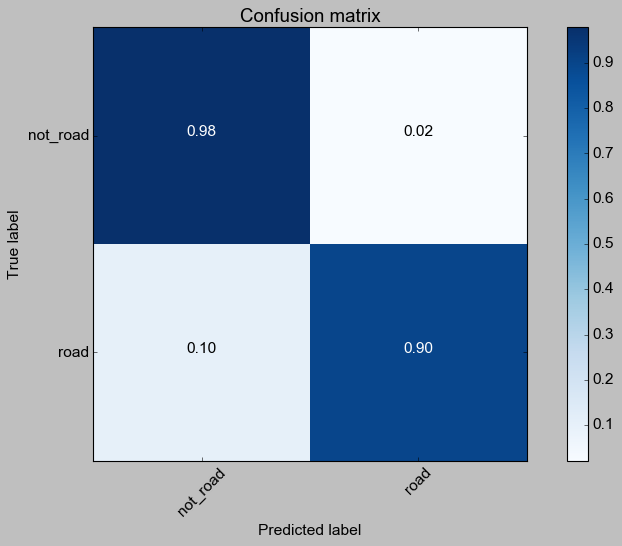

In [12]:
model_name = 'unet'
weights = 'output/experiment0/unet_2019_09_04_12_16/model/best_model.h5'
f_test_c, gt_test_c, model_c, scores_c, pred_c, times_c, conf_mat_c = evaluate_model(model_name, weights, view='front', plot_result_flag=False)

In [9]:
print("Scores:", scores_c)
print("Mean prediction time: ", times_c[1:].mean())

Scores: {'f1': 0.8480522650918941, 'recall': 0.8963813970633409, 'precision': 0.8046679388049989, 'acc': 0.9711227465535525, 'jaccard': 0.7361898803156599}
Mean prediction time:  0.009657021226554081


25


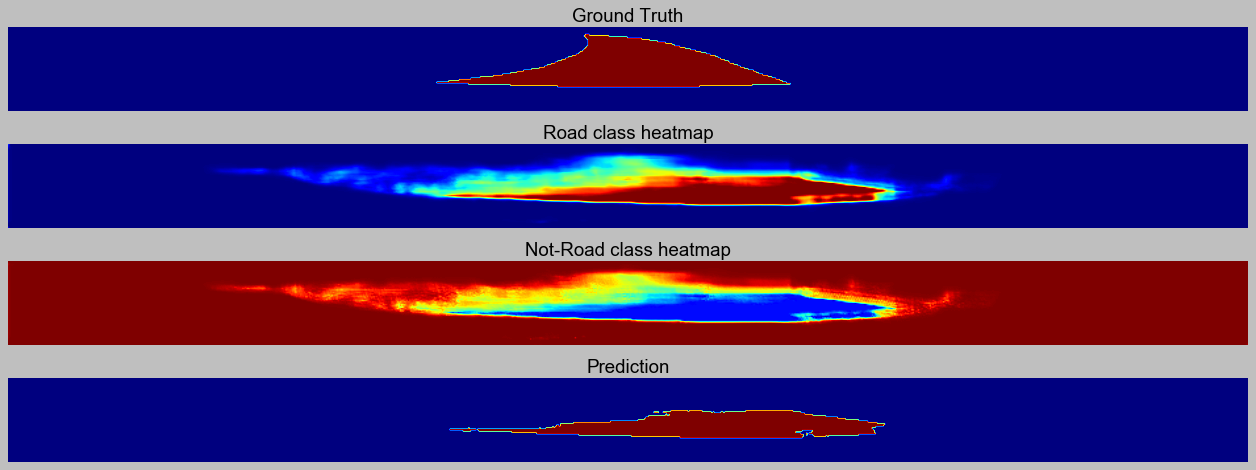

In [10]:
n = np.random.randint(len(gt_test_c))
print(n)
# n = 12
f, ax = plt.subplots(4, 1, figsize=(20,7))
ax[0].imshow(gt_test_c[n, :, :, 0])
ax[0].set_title('Ground Truth')
ax[0].axis('off')
ax[1].imshow(pred_c[n, :, :, 0])
ax[1].set_title('Road class heatmap'.format(n))
ax[1].axis('off')
ax[2].imshow(pred_c[n, :, :, 1])
ax[2].set_title('Not-Road class heatmap'.format(n))
ax[2].axis('off')

ax[3].imshow(1 - np.argmax(pred_c[n, :, :, :], axis=2))
ax[3].set_title('Prediction'.format(n))
ax[3].axis('off')
# plt.tight_layout()
plt.savefig('pred_classic_geom_sub_hog.eps', dpi=90)

plt.show()

### Classic + Geometric + Subsampled 32

100%|██████████| 30/30 [00:00<00:00, 3249.72it/s]

{'name': 'experiment0', 'test_name': 'Classical_Geometric_Subsampled_32', 'run_id': 'unet_2019_09_04_15_26', 'dataset': 'KITTI', 'training_config': {'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}}
{'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}
dict_keys(['imgs', 'calib', 'gt', 'gt_bev', 'gt_front', 'lodnn_gt', 'pc'])
Reading cloud
Reading calibration files
Reading camera images


(259, 2)
Height ranges from -30.21500015258789 to 2.9130001068115234
Read and Subsample cloud
Evaluated in : 0.8330681324005127
Evaluating count
Count varies from 0 to 10
Extracting features
Evaluated in : 1.362985610961914
Test set shape (30, 32, 943, 9)
GT set shape (30, 64, 943, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 944, 9)   0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 32, 944, 8)   656         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 32, 472, 8)   0           conv2d_58[0][0]                  
_____________________

Normalized confusion matrix
[[0.99254153 0.00745847]
 [0.09986484 0.90013516]]
Overall Accuracy: 0.9842341595970308
IoU: 0.9098938184001981


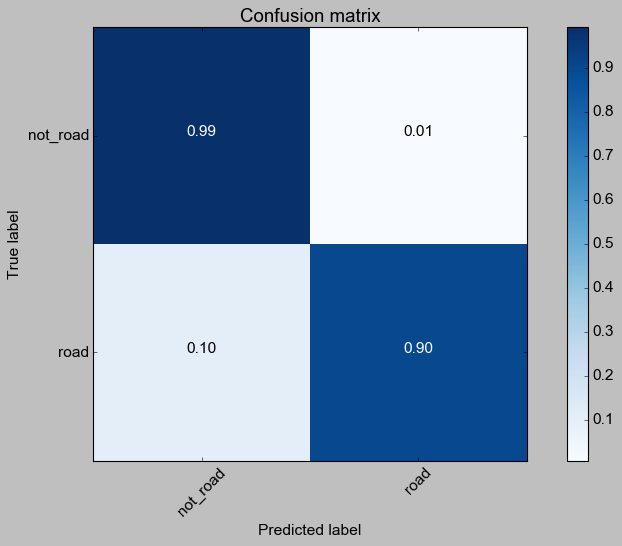

In [15]:
model_name = 'unet'
weights = 'output/experiment0/unet_2019_09_04_15_26/model/best_model.h5'
f_test_c_g_s_32, gt_test_c_g_s_32, model_c_g_s_32, scores_c_g_s_32, pred_c_g_s_32, times_c_g_s_32, conf_mat_c_g_s_32 = evaluate_model(model_name, weights, view='front', plot_result_flag=False)

In [16]:
print("Scores:", scores_c_g_s_32)
print("Mean prediction time: ", times_c_g_s_32[1:].mean())

Scores: {'f1': 0.9112337712819715, 'recall': 0.9001351600417767, 'precision': 0.9226094896256415, 'acc': 0.9842341595970308, 'jaccard': 0.8369416200159945}
Mean prediction time:  0.007683384007421033


24


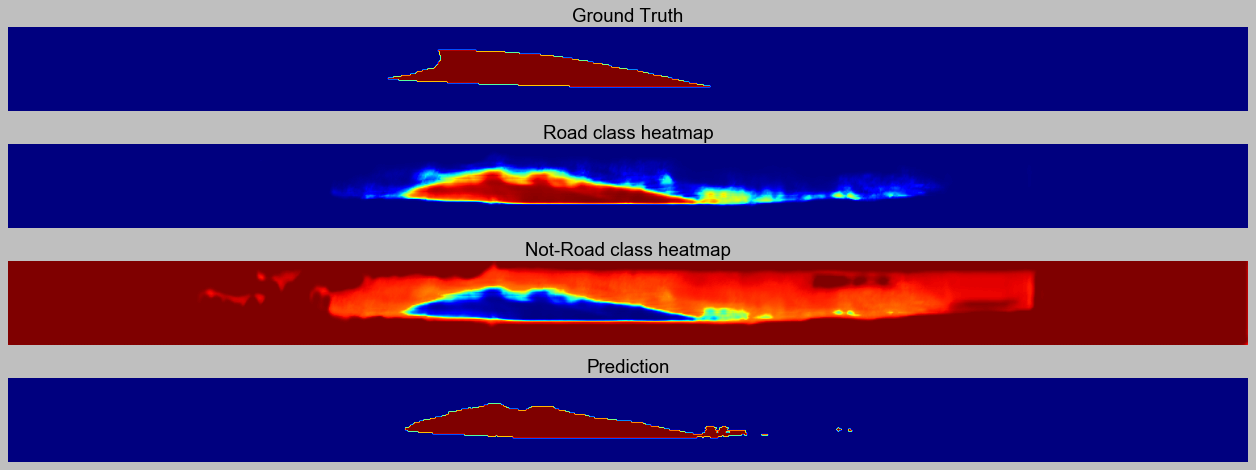

In [20]:
n = np.random.randint(len(gt_test_c))
print(n)
# n = 12
f, ax = plt.subplots(4, 1, figsize=(20,7))
ax[0].imshow(gt_test_c_g_s_32[n, :, :, 0])
ax[0].set_title('Ground Truth')
ax[0].axis('off')
ax[1].imshow(pred_c_g_s_32[n, :, :, 0])
ax[1].set_title('Road class heatmap'.format(n))
ax[1].axis('off')
ax[2].imshow(pred_c_g_s_32[n, :, :, 1])
ax[2].set_title('Not-Road class heatmap'.format(n))
ax[2].axis('off')

ax[3].imshow(1 - np.argmax(pred_c_g_s_32[n, :, :, :], axis=2))
ax[3].set_title('Prediction'.format(n))
ax[3].axis('off')
# plt.tight_layout()
plt.savefig('pred_classic_geom_sub_hog.eps', dpi=90)

plt.show()

### Classic + Subsampled 32

100%|██████████| 30/30 [00:00<00:00, 3496.90it/s]

{'name': 'experiment0', 'test_name': 'Classical_Subsampled_32', 'run_id': 'unet_2019_09_04_15_57', 'dataset': 'KITTI', 'training_config': {'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}}
{'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}
dict_keys(['imgs', 'calib', 'gt', 'gt_bev', 'gt_front', 'lodnn_gt', 'pc'])
Reading cloud
Reading calibration files
Reading camera images


(259, 2)
Height ranges from -30.21500015258789 to 2.9130001068115234
Read and Subsample cloud
Evaluated in : 0.8589541912078857
Evaluating count
Count varies from 0 to 10
Extracting features
Evaluated in : 1.7034094333648682
Test set shape (30, 32, 943, 6)
GT set shape (30, 64, 943, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 944, 6)   0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 32, 944, 8)   440         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 32, 472, 8)   0           conv2d_70[0][0]                  
____________________

/home/leonardo/Dev/github/crispy-eureka/nbs/dl_models.py:109: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = keras.models.Model(input = inputs, output = conv10)


Elapsed time to exectute predict_sample: 0.1946413516998291
Elapsed time to exectute predict_sample: 0.007360219955444336
Elapsed time to exectute predict_sample: 0.007120370864868164
Elapsed time to exectute predict_sample: 0.008690595626831055
Elapsed time to exectute predict_sample: 0.007005929946899414
Elapsed time to exectute predict_sample: 0.007026195526123047
Elapsed time to exectute predict_sample: 0.0070037841796875
Elapsed time to exectute predict_sample: 0.0070574283599853516
Elapsed time to exectute predict_sample: 0.0070171356201171875
Elapsed time to exectute predict_sample: 0.006975650787353516
Elapsed time to exectute predict_sample: 0.006891965866088867
Elapsed time to exectute predict_sample: 0.006954193115234375
Elapsed time to exectute predict_sample: 0.00695490837097168
Elapsed time to exectute predict_sample: 0.007014751434326172
Elapsed time to exectute predict_sample: 0.006934642791748047
Elapsed time to exectute predict_sample: 0.006943941116333008
Elapsed tim

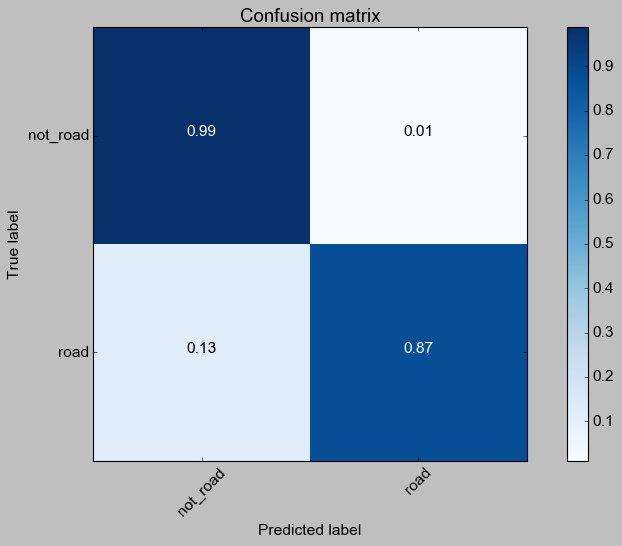

In [21]:
model_name = 'unet'
weights = 'output/experiment0/unet_2019_09_04_15_57/model/best_model.h5'
f_test_c_s_32, gt_test_c_s_32, model_c_s_32, scores_c_s_32, pred_c_s_32, times_c_s_32, conf_mat_c_s_32 = evaluate_model(model_name, weights, view='front', plot_result_flag=False)

In [22]:
print("Scores:", scores_c_s_32)
print("Mean prediction time: ", times_c_s_32[1:].mean())

Scores: {'f1': 0.8766687818431608, 'recall': 0.8742397247650059, 'precision': 0.8791113747003731, 'acc': 0.9778863997879109, 'jaccard': 0.78041878270026}
Mean prediction time:  0.007164988024481411


21


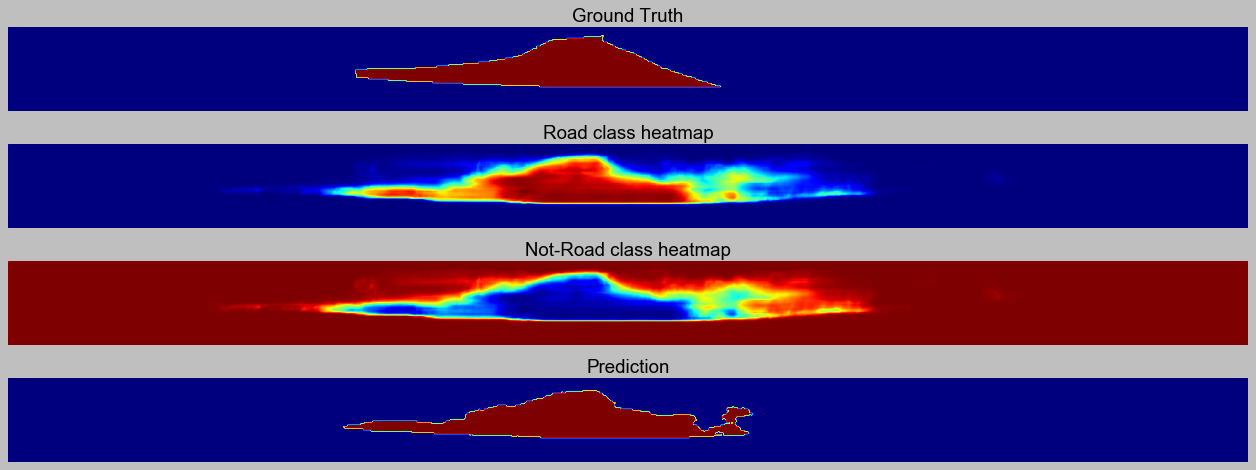

In [23]:
n = np.random.randint(len(gt_test_c))
print(n)
# n = 12
f, ax = plt.subplots(4, 1, figsize=(20,7))
ax[0].imshow(gt_test_c_s_32[n, :, :, 0])
ax[0].set_title('Ground Truth')
ax[0].axis('off')
ax[1].imshow(pred_c_s_32[n, :, :, 0])
ax[1].set_title('Road class heatmap'.format(n))
ax[1].axis('off')
ax[2].imshow(pred_c_s_32[n, :, :, 1])
ax[2].set_title('Not-Road class heatmap'.format(n))
ax[2].axis('off')

ax[3].imshow(1 - np.argmax(pred_c_s_32[n, :, :, :], axis=2))
ax[3].set_title('Prediction'.format(n))
ax[3].axis('off')
# plt.tight_layout()
plt.savefig('pred_classic_geom_sub_hog.eps', dpi=90)

plt.show()

### Classic + Geometric + Subsampled 16

100%|██████████| 30/30 [00:00<00:00, 3348.30it/s]

{'name': 'experiment0', 'test_name': 'Classical_Geometric_Subsampled_16', 'run_id': 'unet_2019_09_04_15_22', 'dataset': 'KITTI', 'training_config': {'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}}
{'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}
dict_keys(['imgs', 'calib', 'gt', 'gt_bev', 'gt_front', 'lodnn_gt', 'pc'])
Reading cloud
Reading calibration files
Reading camera images


(259, 2)
Height ranges from -30.21500015258789 to 2.9130001068115234
Read and Subsample cloud
Evaluated in : 0.8061580657958984
Evaluating count
Count varies from 0 to 6
Extracting features
Evaluated in : 1.0686793327331543
Test set shape (30, 16, 943, 9)
GT set shape (30, 64, 943, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16, 944, 9)   0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 16, 944, 8)   656         input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 16, 472, 8)   0           conv2d_108[0][0]                 
_____________________

Scores: F1 -> 0.878582398256174, Recall -> 0.8716409657799349, Precision -> 0.8856352763455224, Accuracy -> 0.9783415075998586, Jaccard -> 0.7834569360155944
------------------------------------------------
(30, 64, 943, 2)
(30, 64, 943, 2)
Normalized confusion matrix
[[0.98888147 0.01111853]
 [0.12835903 0.87164097]]
Overall Accuracy: 0.9783415075998586
IoU: 0.8799784831394909


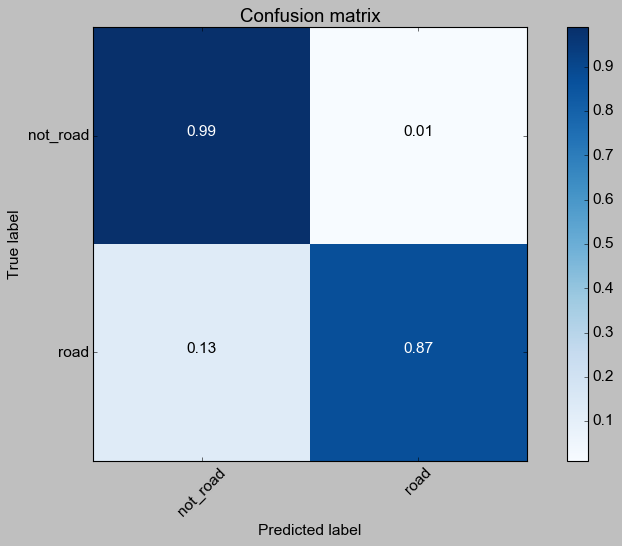

In [26]:
model_name = 'unet'
weights = 'output/experiment0/unet_2019_09_04_15_22/model/best_model.h5'
f_test_c_g_s_16, gt_test_c_g_s_16, model_c_g_s_16, scores_c_g_s_16, pred_c_g_s_16, times_c_g_s_16, conf_mat_c_g_s_16 = evaluate_model(model_name, weights, view='front', plot_result_flag=False)

In [31]:
print("Scores:", scores_c_g_s_16)
print("Mean prediction time: ", times_c_g_s_16[1:].mean())

Scores: {'f1': 0.878582398256174, 'recall': 0.8716409657799349, 'precision': 0.8856352763455224, 'acc': 0.9783415075998586, 'jaccard': 0.7834569360155944}
Mean prediction time:  0.006406159236513335


0


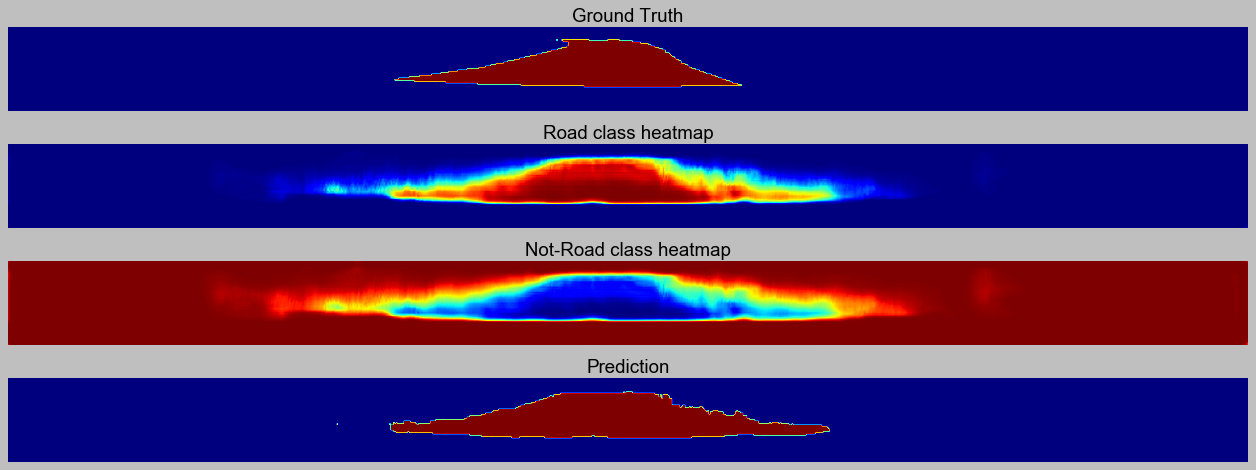

In [28]:
n = np.random.randint(len(gt_test_c))
print(n)
# n = 12
f, ax = plt.subplots(4, 1, figsize=(20,7))
ax[0].imshow(gt_test_c_g_s_16[n, :, :, 0])
ax[0].set_title('Ground Truth')
ax[0].axis('off')
ax[1].imshow(pred_c_g_s_16[n, :, :, 0])
ax[1].set_title('Road class heatmap'.format(n))
ax[1].axis('off')
ax[2].imshow(pred_c_g_s_16[n, :, :, 1])
ax[2].set_title('Not-Road class heatmap'.format(n))
ax[2].axis('off')

ax[3].imshow(1 - np.argmax(pred_c_g_s_16[n, :, :, :], axis=2))
ax[3].set_title('Prediction'.format(n))
ax[3].axis('off')
# plt.tight_layout()
plt.savefig('pred_classic_geom_sub_hog.eps', dpi=90)

plt.show()

### Classic + Subsample 16

100%|██████████| 30/30 [00:00<00:00, 3328.46it/s]

{'name': 'experiment0', 'test_name': 'Classical_Subsampled_16', 'run_id': 'unet_2019_09_04_15_50', 'dataset': 'KITTI', 'training_config': {'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}}
{'loss_function': 'binary_crossentropy', 'learning_rate': 0.001, 'batch_size': 3, 'epochs': 120, 'optimizer': 'keras.optimizers.Adam'}
dict_keys(['imgs', 'calib', 'gt', 'gt_bev', 'gt_front', 'lodnn_gt', 'pc'])
Reading cloud
Reading calibration files
Reading camera images


(259, 2)
Height ranges from -30.21500015258789 to 2.9130001068115234
Read and Subsample cloud
Evaluated in : 0.8248066902160645
Evaluating count
Count varies from 0 to 6
Extracting features
Evaluated in : 1.1857080459594727
Test set shape (30, 16, 943, 6)
GT set shape (30, 64, 943, 2)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16, 944, 6)   0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 16, 944, 8)   440         input_11[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 16, 472, 8)   0           conv2d_121[0][0]                 
_____________________

Scores: F1 -> 0.8513529321225182, Recall -> 0.8495484425877005, Precision -> 0.8531651036525173, Accuracy -> 0.9733297985153765, Jaccard -> 0.7411788667999507
------------------------------------------------
(30, 64, 943, 2)
(30, 64, 943, 2)
Normalized confusion matrix
[[0.98555702 0.01444298]
 [0.15045156 0.84954844]]
Overall Accuracy: 0.9733297985153765
IoU: 0.8561516511877967


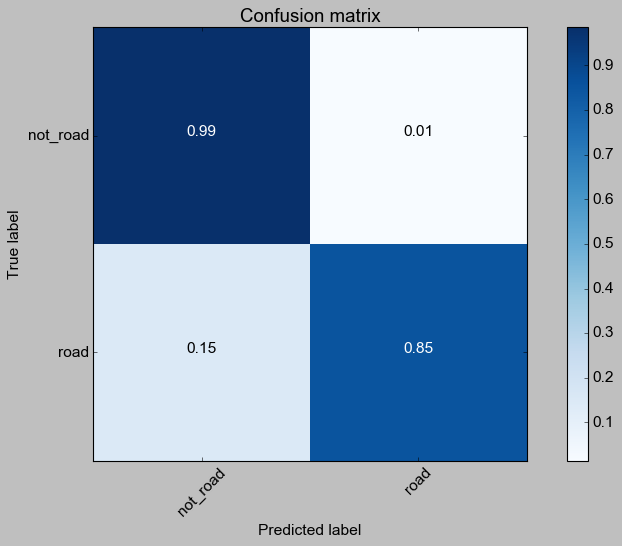

In [29]:
model_name = 'unet'
weights = 'output/experiment0/unet_2019_09_04_15_50/model/best_model.h5'
f_test_c_s_16, gt_test_c_s_16, model_c_s_16, scores_c_s_16, pred_c_s_16, times_c_s_16, conf_mat_c_s_16 = evaluate_model(model_name, weights, view='front', plot_result_flag=False)

In [30]:
print("Scores:", scores_c_s_16)
print("Mean prediction time: ", times_c_s_16[1:].mean())

Scores: {'f1': 0.8513529321225182, 'recall': 0.8495484425877005, 'precision': 0.8531651036525173, 'acc': 0.9733297985153765, 'jaccard': 0.7411788667999507}
Mean prediction time:  0.005926929671188881


23


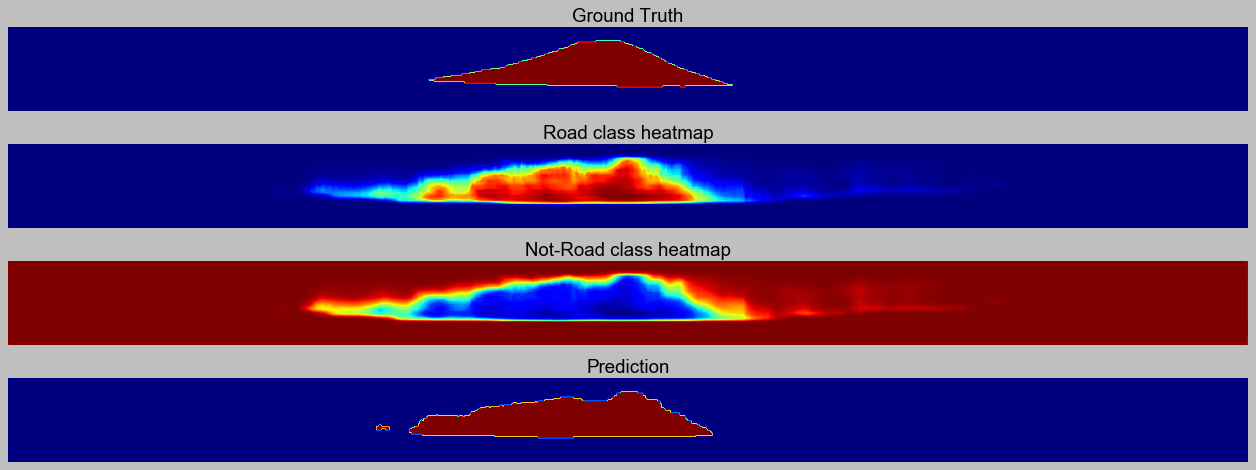

In [32]:
n = np.random.randint(len(gt_test_c))
print(n)
# n = 12
f, ax = plt.subplots(4, 1, figsize=(20,7))
ax[0].imshow(gt_test_c_s_16[n, :, :, 0])
ax[0].set_title('Ground Truth')
ax[0].axis('off')
ax[1].imshow(pred_c_s_16[n, :, :, 0])
ax[1].set_title('Road class heatmap'.format(n))
ax[1].axis('off')
ax[2].imshow(pred_c_s_16[n, :, :, 1])
ax[2].set_title('Not-Road class heatmap'.format(n))
ax[2].axis('off')

ax[3].imshow(1 - np.argmax(pred_c_s_16[n, :, :, :], axis=2))
ax[3].set_title('Prediction'.format(n))
ax[3].axis('off')
# plt.tight_layout()
plt.savefig('pred_classic_geom_sub_hog.eps', dpi=90)

plt.show()

### ROC Curves

In [18]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 18})

In [33]:
gt_c_g     = gt_test_c_g[:,:,:,0].flatten()
p_c_g      = pred_c_g[:,:,:,0].flatten()
prec_c_g, rec_c_g, _ = precision_recall_curve(gt_c_g, p_c_g)

gt_c     = gt_test_c[:,:,:,0].flatten()
p_c      = pred_c[:,:,:,0].flatten()
prec_c, rec_c, _ = precision_recall_curve(gt_c, p_c)

gt_c_g_s_32     = gt_test_c_g_s_32[:,:,:,0].flatten()
p_c_g_s_32      = pred_c_g_s_32[:,:,:,0].flatten()
prec_c_g_s_32, rec_c_g_s_32, _ = precision_recall_curve(gt_c_g_s_32, p_c_g_s_32)

gt_c_s_32     = gt_test_c_s_32[:,:,:,0].flatten()
p_c_s_32      = pred_c_s_32[:,:,:,0].flatten()
prec_c_s_32, rec_c_s_32, _ = precision_recall_curve(gt_c_s_32, p_c_s_32)

gt_c_g_s_16     = gt_test_c_g_s_16[:,:,:,0].flatten()
p_c_g_s_16      = pred_c_g_s_16[:,:,:,0].flatten()
prec_c_g_s_16, rec_c_g_s_16, _ = precision_recall_curve(gt_c_g_s_16, p_c_g_s_16)

gt_c_s_16     = gt_test_c_s_16[:,:,:,0].flatten()
p_c_s_16      = pred_c_s_16[:,:,:,0].flatten()
prec_c_s_16, rec_c_s_16, _ = precision_recall_curve(gt_c_s_16, p_c_s_16)


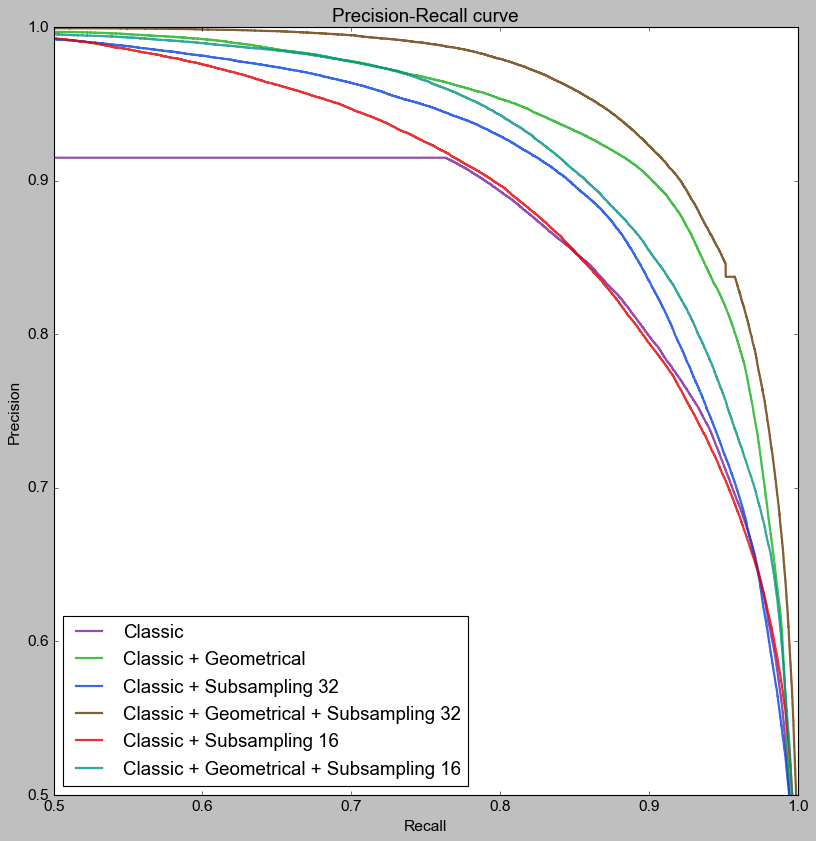

In [35]:
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
plt.figure(figsize=(12,12))

plt.step(rec_c, prec_c, linewidth=2, color='xkcd:purple', alpha=0.8, where='post')
plt.step(rec_c_g, prec_c_g, linewidth=2, color='xkcd:green', alpha=0.8, where='post')

plt.step(rec_c_s_32, prec_c_s_32, linewidth=2, color='xkcd:blue', alpha=0.8, where='post')
plt.step(rec_c_g_s_32, prec_c_g_s_32, linewidth=2, color='xkcd:brown', alpha=0.8, where='post')

plt.step(rec_c_s_16, prec_c_s_16, linewidth=2, color='xkcd:red', alpha=0.8, where='post')
plt.step(rec_c_g_s_16, prec_c_g_s_16, linewidth=2, color='xkcd:teal', alpha=0.8, where='post')
# plt.step(rec_c_g_s, prec_c_g_s, linewidth=2, color='xkcd:orange', alpha=0.8, where='post')
# plt.step(rec_c_g_s_h, prec_c_g_s_h, linewidth=2, color='xkcd:goldenrod', alpha=0.8, where='post')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.5, 1.0])
plt.xlim([0.5, 1.0])
plt.title('Precision-Recall curve')
# plt.legend(['Classic', 'Classic + Geometrical'], loc=3)
plt.legend(['Classic',
            'Classic + Geometrical',
            'Classic + Subsampling 32',
            'Classic + Geometrical + Subsampling 32',
            'Classic + Subsampling 16',
            'Classic + Geometrical + Subsampling 16'], loc=3)